<a href="https://colab.research.google.com/github/anuradhaboche/robo-advisor/blob/master/Efficient_Frontier_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import** **Libraries**

In [49]:
import numpy as np
import sqlite3
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

**Fetch Data from Database/API**
- Set Date as index
- Sort data as per index values

In [148]:
connection = sqlite3.connect('/content/drive/My Drive/portfolio_db.db')
cursor=connection.execute('Select distinct date, "adj close", ticker from stocks_data where Ticker in (\'MMM\',\'AXP\',\'AAPL\',\'BA\',\'CAT\',\'CVX\',\'CSCO\',\'KO\',\'DOW\',\'XOM\',\'GS\',\'HD\',\'IBM\',\'INTC\',\'JNJ\',\'JPM\',\'MCD\',\'MRK\',\'MSFT\',\'NKE\',\'PFE\',\'PG\',\'RTX\',\'TRV\',\'UNH\',\'VZ\',\'V\',\'WMT\',\'WBA\',\'DIS\') and date between \'2010-01-01\' and \'2020-01-01\' order by ticker')
dow_data= pd.DataFrame(cursor.fetchall())
dow_data.columns=[x[0] for x in cursor.description]
# master_stocks_data['Date'] = pd.to_datetime(master_stocks_data.Date,format='%Y-%m-%d')
dow_data.set_index('Date', drop=True, inplace=True)
dow_data.sort_index(inplace=True)
dow_data

,Adj Close,Ticker
Date,,
2010-01-04 00:00:00,26.466835,AAPL
2010-01-04 00:00:00,53.047504,CVX
2010-01-04 00:00:00,42.953705,CAT
2010-01-04 00:00:00,27.933924,DIS
2010-01-04 00:00:00,38.454769,TRV
...,...,...
2019-12-30 00:00:00,118.353401,WMT
2019-12-30 00:00:00,52.516708,DOW
2019-12-30 00:00:00,38.136490,PFE


**Generate index values for Year 2019**

In [126]:
df= dow_data[dow_data['Ticker']=='CSCO']
pred_dates=df.loc['2019-01-01': '2020-01-01'].index

,Adj Close,Ticker
Date,,
2010-01-04 00:00:00,18.785395,CSCO
2010-01-05 00:00:00,18.701702,CSCO
2010-01-06 00:00:00,18.579962,CSCO
2010-01-07 00:00:00,18.663656,CSCO
2010-01-08 00:00:00,18.762569,CSCO
...,...,...
2019-12-23 00:00:00,46.930817,CSCO
2019-12-24 00:00:00,46.618591,CSCO
2019-12-26 00:00:00,46.686893,CSCO


**Split data in training, dev and test set**

In [149]:
def split_data(ticker_stock_data):
      # ticker_stock_data.index= ticker_stock_data['Date']
      trainset=ticker_stock_data.loc['2010-01-01':'2016-01-01'][['Adj Close']]
      devset=ticker_stock_data.loc['2016-01-01':'2019-01-01'][['Adj Close']]
      testset= ticker_stock_data.loc['2019-01-01': '2020-01-01'][['Adj Close']]
      ticker_name= ticker_stock_data['Ticker'][0]
      train_dev= trainset.append(devset)
      num_train= trainset.shape[0]; num_test= testset.shape[0]; num_dev= devset.shape[0]; num_train_dev= train_dev.shape[0]
      parameters= {'ticker_stock_data':ticker_stock_data,'trainset':trainset,'testset':testset, 'devset':devset,'train_dev':train_dev,'num_train':num_train, 'num_test':num_test,'num_dev':num_dev, 'num_train_dev':num_train_dev,'ticker_name':ticker_name}
      return parameters

In [150]:
def get_x_y(data, N, offset):
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    return x, y

**Execute LSTM Model**

In [137]:
def execute_lstm_model(parameters):

  N_opt=41; lstm_units_opt=50; dropout_prob_opt=1; 
  epoch_opt=1; batch_size_opt=1; optimizer_opt='adam'
  trainset=parameters['trainset']; ticker_stock_data= parameters['ticker_stock_data']; train_dev= parameters['train_dev']
  num_train= parameters['num_train']; num_dev= parameters['num_dev']
  scaler= MinMaxScaler(feature_range=(0,1))

  train_dev_scaled= scaler.fit_transform(np.array(train_dev['Adj Close']).reshape(-1,1))
  x_train_dev, y_train_dev= get_x_y(train_dev_scaled, N_opt, N_opt)
  test_scaled  = scaler.transform(np.array(ticker_stock_data['Adj Close']).reshape(-1,1))
  x_test, y_test = get_x_y(test_scaled, N_opt, num_train+num_dev)
  rmse, prediction_list = train_test_lstm_model(x_train_dev, y_train_dev, x_test, y_test, scaler, lstm_units_opt, dropout_prob_opt, optimizer_opt, 
        epoch_opt, batch_size_opt)
  print("RMSE on test set = %0.3f" % rmse)
  return prediction_list


**LSTM Model**

In [138]:
def train_test_lstm_model(x_train_scaled,y_train_scaled,x_dev_scaled,y_dev_scaled,scaler, lstm_units_opt,dropout_prob_opt,optimizer_opt,epoch_opt,batch_size_opt):
  model= Sequential()
  model.add(LSTM(units=lstm_units_opt,return_sequences=True,input_shape=(x_train_scaled.shape[1],1)))
  model.add(Dropout(dropout_prob_opt))
  model.add(LSTM(units=lstm_units_opt))
  model.add(Dropout(dropout_prob_opt))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=optimizer_opt)
  model.fit(x_train_scaled, y_train_scaled, epochs=epoch_opt, batch_size=batch_size_opt, verbose=0)
  forecast=model.predict(x_dev_scaled)
  forecast_inv=scaler.inverse_transform(forecast)
  y_dev = scaler.inverse_transform(y_dev_scaled)
  rmse = math.sqrt(mean_squared_error(y_dev, forecast_inv))

  return rmse, forecast_inv

**Loop over all 30 stocks in Dow Jones**

In [163]:
selected_companies= ['MMM','AXP']
dow_predictions= pd.DataFrame(index=testset.index)
for ticker in selected_companies:
  ticker_data= dow_data[dow_data['Ticker']==ticker]
  parameters= split_data(ticker_data)
  prediction_list=execute_lstm_model(parameters)
  dow_predictions[ticker+'_Pred'] = prediction_list
  # dow_predictions[ticker+'_True'] = testset['Adj Close']

end_price=dow_predictions.iloc[-1]
start_price=dow_predictions.iloc[0]
returns_annual=(end_price-start_price)/start_price
returns_daily = dow_predictions.pct_change()
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 251

num_assets = len(selected_companies)
num_portfolios = 50000
stocks_returns = []
stocks_volatility = []
stocks_weights = []
sharpe_ratio = []

for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    stocks_returns.append(returns)
    stocks_volatility.append(volatility)
    stocks_weights.append(weights)

portfolio = {'Returns': stocks_returns,'Volatility': stocks_volatility, 'Sharpe_Ratio': sharpe_ratio}
for i,symbol in enumerate(selected_companies):
  portfolio[symbol+'_Weight'] = [weights[i] for weights in stocks_weights]

portfolio=pd.DataFrame(portfolio)
portfolio.head()

RMSE on test set = 5.499
RMSE on test set = 1.830


,Returns,Volatility,Sharpe_Ratio,MMM_Weight,AXP_Weight
0,0.073474,0.068819,1.067634,0.703131,0.296869
1,0.155952,0.057082,2.732058,0.481242,0.518758
2,0.188314,0.053942,3.491034,0.394177,0.605823
3,0.311191,0.052659,5.909593,0.063602,0.936398
4,0.280057,0.051282,5.461079,0.147360,0.852640


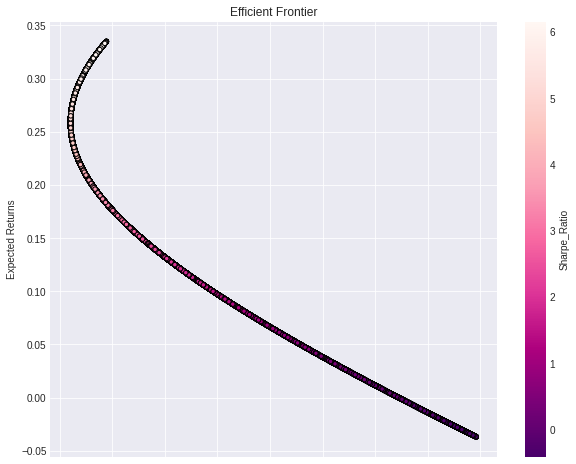

In [164]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-dark')
portfolio.plot.scatter(x='Volatility', y='Returns', c='Sharpe_Ratio',
                cmap='RdPu_r', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [ ]:
min_volatility=portfolio['Volatility'].min()
max_sharpe_ratio= portfolio['Sharpe_Ratio'].max()
print('min_volatility',round(min_volatility,2), '\nmax_sharpe_ratio',round(max_sharpe_ratio,2))

sharpe_portfolio = portfolio.loc[portfolio['Sharpe_Ratio'] == max_sharpe]
min_variance_port = portfolio.loc[portfolio['Volatility'] == min_volatility]
print('sharpe_portfolio',sharpe_portfolio, '\nmin_variance_port',min_variance_port)